# Pipeline Хакатон "Ритм продаж"

Шаги:
1. Загрузка данных.
2. Отложенный `final_holdout` (последние 14 дней train).
3. Построение фичей.
4. Формирование списков признаков.
5. Walk-forward CV сплиты.
6. Тюнинг параметров.
7. Обучение на `train_for_tuning` и проверка на `final_holdout`.
8. Финальное обучение на полном train.
9. Рекурсивный прогноз test.
10. Формирование `submission.csv`.

Во всех важных точках есть `display(...)` таблиц и графики.


In [17]:
import warnings
warnings.filterwarnings('ignore')

from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from features import build_features, make_item_stats
from cv_tuning import (
    make_walk_forward_splits,
    recursive_predict_period,
    tune_two_stage_walk_forward_cv,
)
from modeling import fit_stage1_classifier, fit_stage2_regressor
from metrics import wmae

plt.style.use('seaborn-v0_8-whitegrid')
pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 220)


## Шаг 1. Загрузка и базовая проверка данных

In [18]:
TRAIN_PATH = Path('train.parquet')
TEST_PATH = Path('test.parquet')
SUB_PATH = Path('sample_submission.csv')
OUT_PATH = Path('submission.csv')

assert TRAIN_PATH.exists(), f'Не найден {TRAIN_PATH}'
assert TEST_PATH.exists(), f'Не найден {TEST_PATH}'
assert SUB_PATH.exists(), f'Не найден {SUB_PATH}'

train = pd.read_parquet(TRAIN_PATH)
test = pd.read_parquet(TEST_PATH)
sub_template = pd.read_csv(SUB_PATH)

train['dt'] = pd.to_datetime(train['dt'])
test['dt'] = pd.to_datetime(test['dt'])

if 'qty' not in train.columns:
    raise ValueError('В train нет колонки qty')
if 'qty' in test.columns:
    test = test.drop(columns=['qty'])

train = train.sort_values(['nm_id', 'dt']).reset_index(drop=True)
test = test.sort_values(['nm_id', 'dt']).reset_index(drop=True)

print('train shape:', train.shape)
print('test shape :', test.shape)
print('sample_submission shape:', sub_template.shape)


train shape: (309648, 6)
test shape : (12856, 5)
sample_submission shape: (12856, 3)


In [19]:
print('Пример train:')
display(train.head(8))

print('Пример test:')
display(test.head(8))

print('Типы колонок train:')
display(train.dtypes)


Пример train:


,nm_id,dt,qty,price,is_promo,prev_leftovers
0,0045b02f-cd56-4d2f-9d03-c5f40f1da697,2025-03-17,0,15555,0,573
1,0045b02f-cd56-4d2f-9d03-c5f40f1da697,2025-03-18,0,15555,0,573
2,0045b02f-cd56-4d2f-9d03-c5f40f1da697,2025-03-19,0,15555,0,573
3,0045b02f-cd56-4d2f-9d03-c5f40f1da697,2025-03-20,3,15555,0,573
4,0045b02f-cd56-4d2f-9d03-c5f40f1da697,2025-03-21,0,15555,0,573
5,0045b02f-cd56-4d2f-9d03-c5f40f1da697,2025-03-22,3,15555,0,576
6,0045b02f-cd56-4d2f-9d03-c5f40f1da697,2025-03-23,0,15555,0,576
7,0045b02f-cd56-4d2f-9d03-c5f40f1da697,2025-03-24,3,15555,0,573


Пример test:


,nm_id,dt,price,is_promo,prev_leftovers
0,0045b02f-cd56-4d2f-9d03-c5f40f1da697,2025-07-08,15927,1,540
1,0045b02f-cd56-4d2f-9d03-c5f40f1da697,2025-07-09,16335,1,540
2,0045b02f-cd56-4d2f-9d03-c5f40f1da697,2025-07-10,15927,1,540
3,0045b02f-cd56-4d2f-9d03-c5f40f1da697,2025-07-11,15927,1,537
4,0045b02f-cd56-4d2f-9d03-c5f40f1da697,2025-07-12,15927,1,537
5,0045b02f-cd56-4d2f-9d03-c5f40f1da697,2025-07-13,15927,1,537
6,0045b02f-cd56-4d2f-9d03-c5f40f1da697,2025-07-14,15927,1,537
7,0045b02f-cd56-4d2f-9d03-c5f40f1da697,2025-07-15,15927,1,537


Типы колонок train:


nm_id                        str
dt                datetime64[ns]
qty                        int64
price                      int64
is_promo                   int64
prev_leftovers             int64
dtype: object

### Мини-EDA: как выглядит target `qty`

In [20]:
zero_share = (train['qty'] == 0).mean()
pos_share = (train['qty'] > 0).mean()

print(f'Доля нулевых продаж: {zero_share:.3f}')
print(f'Доля положительных продаж: {pos_share:.3f}')
display(train['qty'].describe(percentiles=[0.5, 0.75, 0.9, 0.95, 0.99]))


Доля нулевых продаж: 0.871
Доля положительных продаж: 0.129


count    309648.000000
mean          0.845906
std           4.888326
min           0.000000
50%           0.000000
75%           0.000000
90%           3.000000
95%           3.000000
99%          12.000000
max         294.000000
Name: qty, dtype: float64

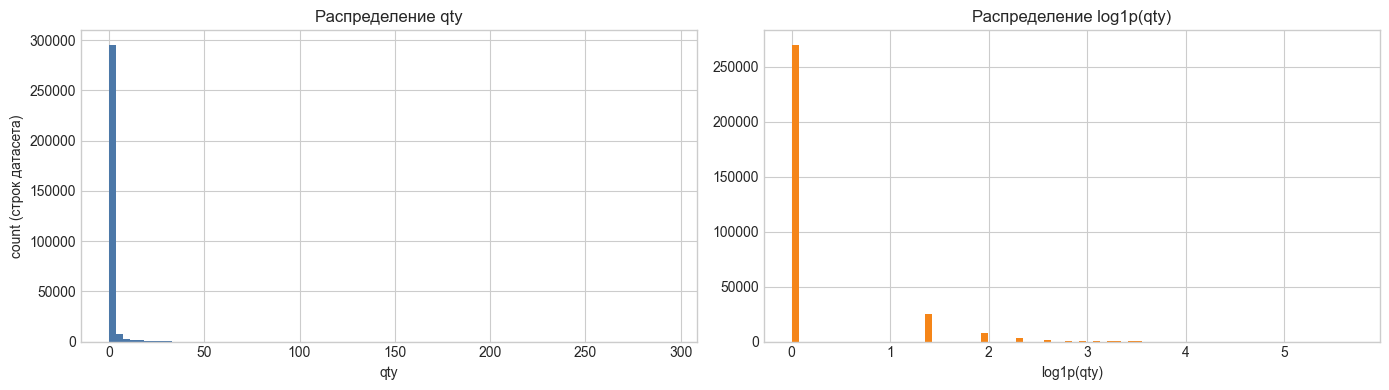

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(14, 4))

ax[0].hist(train['qty'], bins=80, color='#4C78A8')
ax[0].set_title('Распределение qty')
ax[0].set_xlabel('qty')
ax[0].set_ylabel('count (строк датасета)')

ax[1].hist(np.log1p(train['qty']), bins=80, color='#F58518')
ax[1].set_title('Распределение log1p(qty)')
ax[1].set_xlabel('log1p(qty)')

plt.tight_layout()
plt.show()


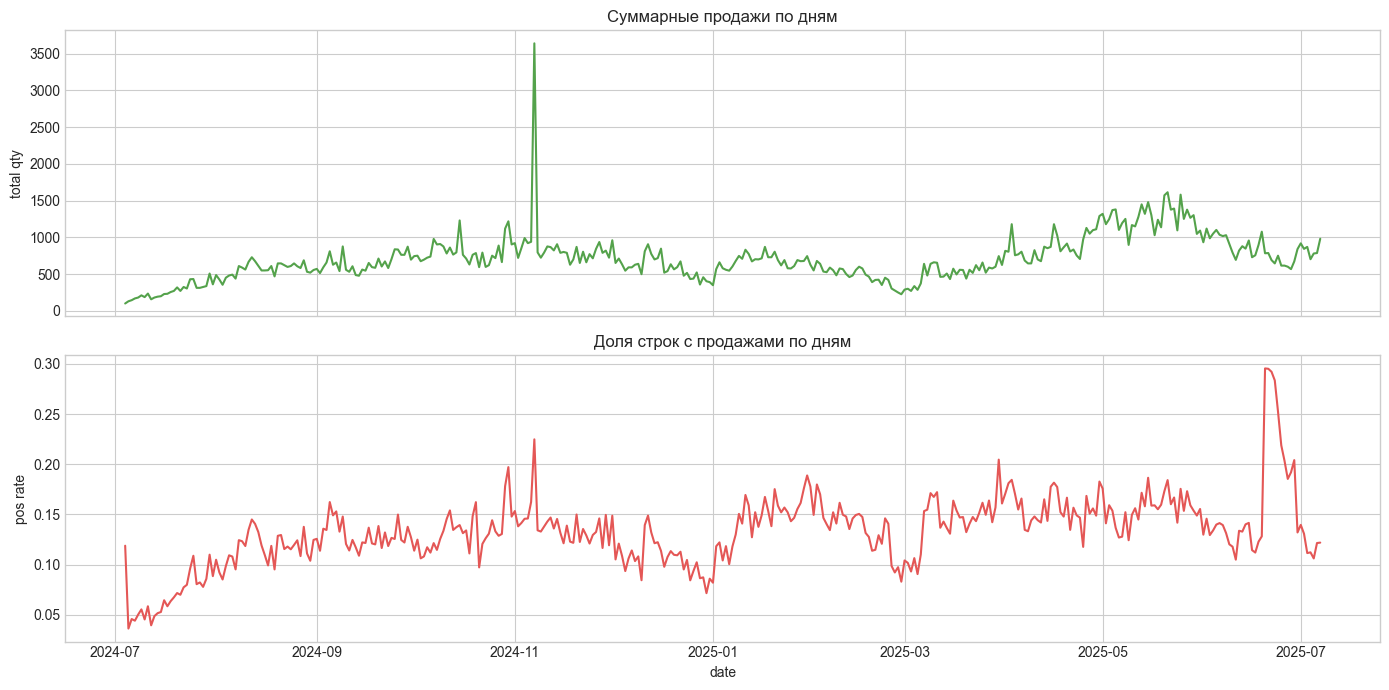

In [24]:
daily = train.groupby('dt', as_index=False).agg(
    total_qty=('qty', 'sum'),
    pos_rate=('qty', lambda x: (x > 0).mean())
)

fig, ax = plt.subplots(2, 1, figsize=(14, 7), sharex=True)
ax[0].plot(daily['dt'], daily['total_qty'], color='#54A24B')
ax[0].set_title('Суммарные продажи по дням')
ax[0].set_ylabel('total qty')

ax[1].plot(daily['dt'], daily['pos_rate'], color='#E45756')
ax[1].set_title('Доля строк с продажами по дням')
ax[1].set_ylabel('pos rate')
ax[1].set_xlabel('date')

plt.tight_layout()
plt.show()


## Шаг 2. Отдельный `final_holdout` (последние 14 дней train)

Это нужно, чтобы финальная оценка не была оптимистичной.


In [25]:
FINAL_HOLDOUT_DAYS = 14

max_dt = train['dt'].max()
holdout_start = max_dt - pd.Timedelta(days=FINAL_HOLDOUT_DAYS - 1)

train_for_tuning = train[train['dt'] < holdout_start].copy()
final_holdout = train[train['dt'] >= holdout_start].copy()

print('max_dt:', max_dt.date())
print('holdout_start:', holdout_start.date())
print('train_for_tuning shape:', train_for_tuning.shape)
print('final_holdout shape   :', final_holdout.shape)

display(final_holdout.head(8))


max_dt: 2025-07-07
holdout_start: 2025-06-24
train_for_tuning shape: (300144, 6)
final_holdout shape   : (9504, 6)


,nm_id,dt,qty,price,is_promo,prev_leftovers
95,0045b02f-cd56-4d2f-9d03-c5f40f1da697,2025-06-30,0,15927,1,531
96,0045b02f-cd56-4d2f-9d03-c5f40f1da697,2025-07-01,0,15927,1,537
97,0045b02f-cd56-4d2f-9d03-c5f40f1da697,2025-07-02,0,15927,1,537
98,0045b02f-cd56-4d2f-9d03-c5f40f1da697,2025-07-03,0,15927,1,537
99,0045b02f-cd56-4d2f-9d03-c5f40f1da697,2025-07-04,0,15927,1,537
100,0045b02f-cd56-4d2f-9d03-c5f40f1da697,2025-07-05,0,15927,1,540
101,0045b02f-cd56-4d2f-9d03-c5f40f1da697,2025-07-06,0,15927,1,540
102,0045b02f-cd56-4d2f-9d03-c5f40f1da697,2025-07-07,0,15927,1,540


## Шаг 3. Построение фичей на `train_for_tuning`

In [26]:
item_stats_tune = make_item_stats(train_for_tuning)
tune_train_feat = build_features(train_for_tuning, item_stats=item_stats_tune)

print('Колонок до фичей :', train_for_tuning.shape[1])
print('Колонок после    :', tune_train_feat.shape[1])

new_cols = [c for c in tune_train_feat.columns if c not in train_for_tuning.columns]
print('Новые признаки (пример):')
print(new_cols[:30])

display(tune_train_feat.head(8))


Колонок до фичей : 6
Колонок после    : 41
Новые признаки (пример):
['dow', 'weekofyear', 'month', 'is_weekend', 'qty_lag_1', 'qty_lag_2', 'qty_lag_7', 'qty_lag_14', 'qty_roll_mean_7', 'qty_roll_mean_14', 'qty_roll_median_7', 'qty_roll_max_14', 'qty_pos_lag_1', 'qty_pos_roll_7', 'qty_pos_roll_14', 'days_since_last_sale', 'price_lag_1', 'price_lag_7', 'price_lag_14', 'price_change_1', 'price_change_7', 'price_roll_mean_28', 'price_rel', 'leftovers_lag_1', 'leftovers_lag_7', 'leftovers_change_1', 'stockout_flag', 'low_stock_flag', 'promo_x_price_rel', 'promo_x_price_change_7']


,nm_id,dt,qty,price,is_promo,prev_leftovers,dow,weekofyear,month,is_weekend,qty_lag_1,qty_lag_2,qty_lag_7,qty_lag_14,qty_roll_mean_7,qty_roll_mean_14,qty_roll_median_7,qty_roll_max_14,qty_pos_lag_1,qty_pos_roll_7,qty_pos_roll_14,days_since_last_sale,price_lag_1,price_lag_7,price_lag_14,price_change_1,price_change_7,price_roll_mean_28,price_rel,leftovers_lag_1,leftovers_lag_7,leftovers_change_1,stockout_flag,low_stock_flag,promo_x_price_rel,promo_x_price_change_7,item_mean_qty,item_median_qty,item_pos_rate,item_mean_price,item_promo_rate
0,0045b02f-cd56-4d2f-9d03-c5f40f1da697,2025-03-17,0,15555,0,573,0,12,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN,NaN,0.884211,0.0,0.221053,16260.315789,0.421053
1,0045b02f-cd56-4d2f-9d03-c5f40f1da697,2025-03-18,0,15555,0,573,1,12,3,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,15555.0,NaN,NaN,0.0,NaN,NaN,NaN,573.0,NaN,0.000000,0,0,NaN,NaN,0.884211,0.0,0.221053,16260.315789,0.421053
2,0045b02f-cd56-4d2f-9d03-c5f40f1da697,2025-03-19,0,15555,0,573,2,12,3,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,15555.0,NaN,NaN,0.0,NaN,NaN,NaN,573.0,NaN,0.000000,0,0,NaN,NaN,0.884211,0.0,0.221053,16260.315789,0.421053
3,0045b02f-cd56-4d2f-9d03-c5f40f1da697,2025-03-20,3,15555,0,573,3,12,3,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,15555.0,NaN,NaN,0.0,NaN,NaN,NaN,573.0,NaN,0.000000,0,0,NaN,NaN,0.884211,0.0,0.221053,16260.315789,0.421053
4,0045b02f-cd56-4d2f-9d03-c5f40f1da697,2025-03-21,0,15555,0,573,4,12,3,0,3.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0,15555.0,NaN,NaN,0.0,NaN,NaN,NaN,573.0,NaN,0.000000,0,0,NaN,NaN,0.884211,0.0,0.221053,16260.315789,0.421053
5,0045b02f-cd56-4d2f-9d03-c5f40f1da697,2025-03-22,3,15555,0,576,5,12,3,1,0.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,2.0,15555.0,NaN,NaN,0.0,NaN,NaN,NaN,573.0,NaN,0.005236,0,0,NaN,NaN,0.884211,0.0,0.221053,16260.315789,0.421053
6,0045b02f-cd56-4d2f-9d03-c5f40f1da697,2025-03-23,0,15555,0,576,6,12,3,1,3.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0,15555.0,NaN,NaN,0.0,NaN,NaN,NaN,576.0,NaN,0.000000,0,0,NaN,NaN,0.884211,0.0,0.221053,16260.315789,0.421053
7,0045b02f-cd56-4d2f-9d03-c5f40f1da697,2025-03-24,3,15555,0,573,0,13,3,0,0.0,3.0,0.0,NaN,0.857143,NaN,0.0,NaN,0.0,2.0,NaN,2.0,15555.0,15555.0,NaN,0.0,0.0,NaN,NaN,576.0,573.0,-0.005208,0,0,NaN,0.0,0.884211,0.0,0.221053,16260.315789,0.421053


## Шаг 4. Список признаков для обучения

In [27]:
drop_cols = {'qty', 'dt', '__is_future', '__future_row_id', '__row_id'}
features = [c for c in tune_train_feat.columns if c not in drop_cols]
cat_features = ['nm_id']

print('Количество features:', len(features))
print('Первые 25 features:')
print(features[:25])
print('Категориальные:', cat_features)


Количество features: 39
Первые 25 features:
['nm_id', 'price', 'is_promo', 'prev_leftovers', 'dow', 'weekofyear', 'month', 'is_weekend', 'qty_lag_1', 'qty_lag_2', 'qty_lag_7', 'qty_lag_14', 'qty_roll_mean_7', 'qty_roll_mean_14', 'qty_roll_median_7', 'qty_roll_max_14', 'qty_pos_lag_1', 'qty_pos_roll_7', 'qty_pos_roll_14', 'days_since_last_sale', 'price_lag_1', 'price_lag_7', 'price_lag_14', 'price_change_1', 'price_change_7']
Категориальные: ['nm_id']


## Шаг 5. Walk-forward CV сплиты

In [28]:
splits = make_walk_forward_splits(
    train_df=train_for_tuning,
    valid_days=14,
    n_folds=3,
    step_days=14,
    min_train_days=56,
)

fold_rows = []
for i, (tr, va, va_start, va_end) in enumerate(splits, start=1):
    fold_rows.append({
        'fold': i,
        'train_start': tr['dt'].min().date(),
        'train_end': tr['dt'].max().date(),
        'valid_start': va_start.date(),
        'valid_end': va_end.date(),
        'train_rows': len(tr),
        'valid_rows': len(va),
    })

folds_df = pd.DataFrame(fold_rows)
display(folds_df)


,fold,train_start,train_end,valid_start,valid_end,train_rows,valid_rows
0,1,2024-07-04,2025-05-12,2025-05-13,2025-05-26,267573,10704
1,2,2024-07-04,2025-05-26,2025-05-27,2025-06-09,278277,11786
2,3,2024-07-04,2025-06-09,2025-06-10,2025-06-23,290063,10081


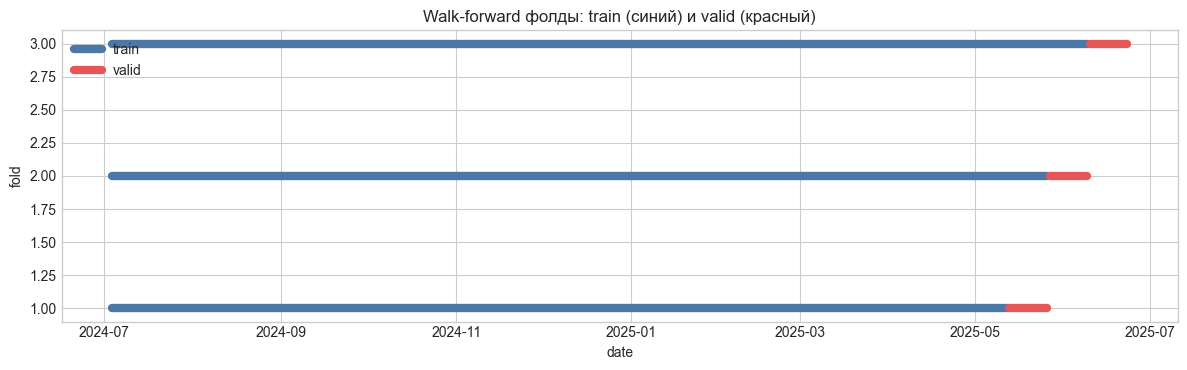

In [29]:
# График: окна train/valid по фолдам
fig, ax = plt.subplots(figsize=(12, 2 + 0.6 * max(1, len(folds_df))))

for _, r in folds_df.iterrows():
    y = int(r['fold'])
    ax.plot([pd.to_datetime(r['train_start']), pd.to_datetime(r['train_end'])], [y, y], color='#4C78A8', lw=6, label='train' if y == 1 else None)
    ax.plot([pd.to_datetime(r['valid_start']), pd.to_datetime(r['valid_end'])], [y, y], color='#E45756', lw=6, label='valid' if y == 1 else None)

ax.set_title('Walk-forward фолды: train (синий) и valid (красный)')
ax.set_xlabel('date')
ax.set_ylabel('fold')
ax.legend(loc='upper left')
plt.tight_layout()
plt.show()


## Шаг 6. Тюнинг гиперпараметров на walk-forward CV

- Сначала подбирается `quantile_alpha`.
- Потом при фиксированном лучшем `quantile_alpha` подбираются `blend_alpha` и `use_floor`.

Можно включить `FAST_MODE=True` для быстрой отладки.


In [30]:
FAST_MODE = False

if FAST_MODE:
    n_folds = 2
    quantile_grid = [0.6, 0.7]
    blend_alpha_grid = np.round(np.arange(1.0, 1.41, 0.1), 2)
else:
    n_folds = 3
    quantile_grid = [0.6, 0.7, 0.8]
    blend_alpha_grid = np.round(np.arange(0.7, 1.61, 0.1), 2)

quantile_alpha, blend_alpha, use_floor, cv_score = tune_two_stage_walk_forward_cv(
    train_df_raw=train_for_tuning,
    features=features,
    cat_features=cat_features,
    n_folds=n_folds,
    valid_days=14,
    step_days=14,
    min_train_days=56,
    quantile_grid=quantile_grid,
    blend_alpha_grid=blend_alpha_grid,
)

print('ЛУЧШИЕ ПАРАМЕТРЫ ПО CV:')
print('quantile_alpha =', quantile_alpha)
print('blend_alpha    =', blend_alpha)
print('use_floor      =', use_floor)
print('CV mean wMAE   =', cv_score)


0:	total: 77.7ms	remaining: 2m 19s
200:	total: 12.7s	remaining: 1m 41s
400:	total: 24.5s	remaining: 1m 25s
600:	total: 36.8s	remaining: 1m 13s
800:	total: 48.7s	remaining: 1m
1000:	total: 1m 1s	remaining: 48.8s
1200:	total: 1m 13s	remaining: 36.7s
1400:	total: 1m 26s	remaining: 24.5s
1600:	total: 1m 38s	remaining: 12.2s
1799:	total: 1m 50s	remaining: 0us
[CV] fold=1 | valid=2025-05-13..2025-05-26 | train_rows=267573 | valid_rows=10704
0:	total: 76.1ms	remaining: 2m 16s
200:	total: 12.8s	remaining: 1m 41s
400:	total: 27.9s	remaining: 1m 37s
600:	total: 42.6s	remaining: 1m 24s
800:	total: 59.3s	remaining: 1m 14s
1000:	total: 1m 12s	remaining: 57.8s
1200:	total: 1m 24s	remaining: 42.3s
1400:	total: 1m 37s	remaining: 27.7s
1600:	total: 1m 49s	remaining: 13.6s
1799:	total: 2m 2s	remaining: 0us
[CV] fold=2 | valid=2025-05-27..2025-06-09 | train_rows=278277 | valid_rows=11786
0:	total: 60.5ms	remaining: 1m 48s
200:	total: 13.5s	remaining: 1m 47s
400:	total: 27.3s	remaining: 1m 35s
600:	total:

## Шаг 7. Честная проверка обобщения на `final_holdout`

Теперь один раз оцениваем модель на данных, которые не участвовали в тюнинге.


In [31]:
clf_tuned = fit_stage1_classifier(tune_train_feat, features, cat_features)
reg_tuned = fit_stage2_regressor(
    tune_train_feat,
    features,
    cat_features,
    quantile_alpha=quantile_alpha,
)

holdout_pred_df = recursive_predict_period(
    history_df=train_for_tuning,
    future_df=final_holdout,
    item_stats=item_stats_tune,
    clf=clf_tuned,
    reg=reg_tuned,
    features=features,
    cat_features=cat_features,
    blend_alpha=blend_alpha,
    use_floor=use_floor,
)

holdout_eval = final_holdout[['nm_id', 'dt', 'qty']].merge(
    holdout_pred_df[['nm_id', 'dt', 'pred_qty']],
    on=['nm_id', 'dt'],
    how='left',
)

holdout_score = wmae(holdout_eval['qty'].values, holdout_eval['pred_qty'].values)
print('Final holdout wMAE =', holdout_score)

display(holdout_eval.head(10))


0:	total: 111ms	remaining: 3m 18s
200:	total: 13.1s	remaining: 1m 44s
400:	total: 25.5s	remaining: 1m 28s
600:	total: 38s	remaining: 1m 15s
800:	total: 50.6s	remaining: 1m 3s
1000:	total: 1m 3s	remaining: 50.5s
1200:	total: 1m 15s	remaining: 37.9s
1400:	total: 1m 28s	remaining: 25.3s
1600:	total: 1m 41s	remaining: 12.6s
1799:	total: 1m 55s	remaining: 0us
0:	learn: 5.1581584	total: 23.9ms	remaining: 1m 16s
200:	learn: 2.1440624	total: 2.5s	remaining: 37.3s
400:	learn: 1.9365130	total: 4.74s	remaining: 33.1s
600:	learn: 1.7049131	total: 6.93s	remaining: 30s
800:	learn: 1.6150069	total: 9.22s	remaining: 27.6s
1000:	learn: 1.5716763	total: 11.2s	remaining: 24.6s
1200:	learn: 1.5481529	total: 13.1s	remaining: 21.8s
1400:	learn: 1.5281833	total: 15s	remaining: 19.3s
1600:	learn: 1.5138800	total: 16.9s	remaining: 16.8s
1800:	learn: 1.5034304	total: 18.8s	remaining: 14.6s
2000:	learn: 1.4957912	total: 20.6s	remaining: 12.3s
2200:	learn: 1.4882923	total: 22.4s	remaining: 10.2s
2400:	learn: 1.48

,nm_id,dt,qty,pred_qty
0,0045b02f-cd56-4d2f-9d03-c5f40f1da697,2025-06-30,0,0.0
1,0045b02f-cd56-4d2f-9d03-c5f40f1da697,2025-07-01,0,0.0
2,0045b02f-cd56-4d2f-9d03-c5f40f1da697,2025-07-02,0,1.0
3,0045b02f-cd56-4d2f-9d03-c5f40f1da697,2025-07-03,0,0.0
4,0045b02f-cd56-4d2f-9d03-c5f40f1da697,2025-07-04,0,0.0
5,0045b02f-cd56-4d2f-9d03-c5f40f1da697,2025-07-05,0,1.0
6,0045b02f-cd56-4d2f-9d03-c5f40f1da697,2025-07-06,0,1.0
7,0045b02f-cd56-4d2f-9d03-c5f40f1da697,2025-07-07,0,1.0
8,0082ae57-7d24-4d43-b743-3abbd590c5aa,2025-06-24,0,0.0
9,0082ae57-7d24-4d43-b743-3abbd590c5aa,2025-06-25,0,0.0


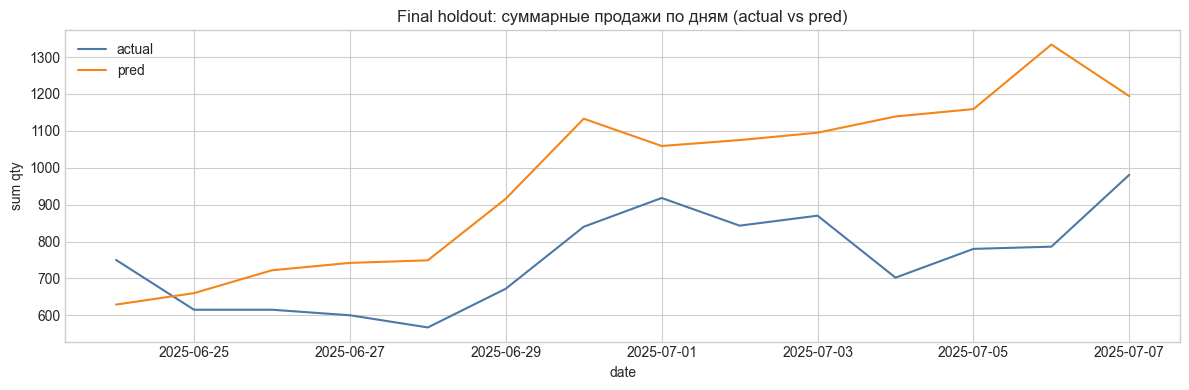

In [32]:
holdout_daily = holdout_eval.groupby('dt', as_index=False).agg(
    actual_qty=('qty', 'sum'),
    pred_qty=('pred_qty', 'sum'),
)

fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(holdout_daily['dt'], holdout_daily['actual_qty'], label='actual', color='#4C78A8')
ax.plot(holdout_daily['dt'], holdout_daily['pred_qty'], label='pred', color='#F58518')
ax.set_title('Final holdout: суммарные продажи по дням (actual vs pred)')
ax.set_xlabel('date')
ax.set_ylabel('sum qty')
ax.legend()
plt.tight_layout()
plt.show()


## Шаг 8. Финальное обучение на полном train

In [33]:
item_stats_full = make_item_stats(train)
full_train_feat = build_features(train, item_stats=item_stats_full)

clf_full = fit_stage1_classifier(full_train_feat, features, cat_features)
reg_full = fit_stage2_regressor(
    full_train_feat,
    features,
    cat_features,
    quantile_alpha=quantile_alpha,
)

print('Финальные модели обучены на полном train.')


0:	total: 130ms	remaining: 3m 53s
200:	total: 14s	remaining: 1m 51s
400:	total: 27.2s	remaining: 1m 35s
600:	total: 40.5s	remaining: 1m 20s
800:	total: 53.2s	remaining: 1m 6s
1000:	total: 1m 6s	remaining: 52.9s
1200:	total: 1m 20s	remaining: 40.4s
1400:	total: 1m 34s	remaining: 26.8s
1600:	total: 1m 47s	remaining: 13.3s
1799:	total: 2m	remaining: 0us
0:	learn: 5.1427016	total: 35.9ms	remaining: 1m 54s
200:	learn: 2.1557093	total: 2.36s	remaining: 35.3s
400:	learn: 1.9624331	total: 4.59s	remaining: 32.1s
600:	learn: 1.7863462	total: 6.69s	remaining: 28.9s
800:	learn: 1.7061351	total: 8.9s	remaining: 26.7s
1000:	learn: 1.6664385	total: 10.9s	remaining: 24s
1200:	learn: 1.6455770	total: 12.9s	remaining: 21.5s
1400:	learn: 1.6240674	total: 15s	remaining: 19.2s
1600:	learn: 1.6028262	total: 17s	remaining: 17s
1800:	learn: 1.5933407	total: 19s	remaining: 14.8s
2000:	learn: 1.5801263	total: 21s	remaining: 12.6s
2200:	learn: 1.5671922	total: 23s	remaining: 10.4s
2400:	learn: 1.5586372	total: 2

## Шаг 9. Рекурсивный прогноз test

In [34]:
test_pred_df = recursive_predict_period(
    history_df=train,
    future_df=test,
    item_stats=item_stats_full,
    clf=clf_full,
    reg=reg_full,
    features=features,
    cat_features=cat_features,
    blend_alpha=blend_alpha,
    use_floor=use_floor,
)

test_pred_df = test_pred_df.sort_values('__future_row_id').reset_index(drop=True)

display(test_pred_df.head(10))


,nm_id,dt,pred_qty,__future_row_id
0,0045b02f-cd56-4d2f-9d03-c5f40f1da697,2025-07-08,0.0,0
1,0045b02f-cd56-4d2f-9d03-c5f40f1da697,2025-07-09,0.0,1
2,0045b02f-cd56-4d2f-9d03-c5f40f1da697,2025-07-10,2.0,2
3,0045b02f-cd56-4d2f-9d03-c5f40f1da697,2025-07-11,0.0,3
4,0045b02f-cd56-4d2f-9d03-c5f40f1da697,2025-07-12,0.0,4
5,0045b02f-cd56-4d2f-9d03-c5f40f1da697,2025-07-13,0.0,5
6,0045b02f-cd56-4d2f-9d03-c5f40f1da697,2025-07-14,0.0,6
7,0045b02f-cd56-4d2f-9d03-c5f40f1da697,2025-07-15,0.0,7
8,0045b02f-cd56-4d2f-9d03-c5f40f1da697,2025-07-16,1.0,8
9,0045b02f-cd56-4d2f-9d03-c5f40f1da697,2025-07-17,0.0,9


## Шаг 10. Формирование `submission.csv`

In [35]:
sub = pd.read_csv(SUB_PATH)

if {'nm_id', 'dt'}.issubset(sub.columns):
    sub['dt'] = pd.to_datetime(sub['dt'])
    sub = sub.drop(columns=['qty'], errors='ignore')
    sub = sub.merge(
        test_pred_df[['nm_id', 'dt', 'pred_qty']].rename(columns={'pred_qty': 'qty'}),
        on=['nm_id', 'dt'],
        how='left',
    )
elif 'id' in sub.columns and len(sub) == len(test_pred_df):
    sub['qty'] = test_pred_df['pred_qty'].values
else:
    raise ValueError('Не распознал формат sample_submission.csv')

sub['qty'] = np.clip(sub['qty'].astype('float64').values, 0.0, np.inf)
sub.to_csv(OUT_PATH, index=False)

print('Saved:', OUT_PATH)
display(sub.head(10))


Saved: submission.csv


,nm_id,dt,qty
0,0045b02f-cd56-4d2f-9d03-c5f40f1da697,2025-07-08,0.0
1,0082ae57-7d24-4d43-b743-3abbd590c5aa,2025-07-08,0.0
2,00b4b259-c2d5-4122-888a-43a0087fc5f5,2025-07-08,0.0
3,00d0ffa6-c650-4ddf-9e69-4200ed4e2554,2025-07-08,2.0
4,00d951b5-ae02-4774-a408-1b98200b1577,2025-07-08,0.0
5,0106ee9e-0af4-48ef-90cb-e80808020872,2025-07-08,0.0
6,0132134f-7063-4b66-a555-2cdd83e63c56,2025-07-08,0.0
7,01898b6a-31ea-4aa1-a13d-c7db8ee2c709,2025-07-08,0.0
8,01de990c-9a97-4b05-ab23-4ebc85b9c803,2025-07-08,0.0
9,01e34721-677f-4300-95e2-c965efdd1290,2025-07-08,0.0


## Краткий итог

- Мы не подсматриваем в будущее.
- Тюнинг (подбор лучших гиперпараметров) идет по walk-forward CV.
- Финальная проверка качества идет на отдельном holdout.
- После этого обучаемся на полном train и делаем прогноз test.


<small>**P.S.** Мы специально отделяем последние 14 дней train в `final_holdout`, чтобы получить менее оптимистичную и более честную оценку качества. Гиперпараметры подбираются только на `train_for_tuning` через walk-forward CV (без использования `final_holdout`). Затем, когда параметры зафиксированы, мы один раз проверяем обобщающую способность на `final_holdout`. И только после этой проверки переобучаем финальные модели на полном `train` с уже выбранными параметрами и делаем прогноз для `test`.</small>